<a href="https://colab.research.google.com/github/Chris-Miracle/fraud-detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

A banking system needs to urgently get rid of fraudulent transaction, it does this by working with datasets on card transactions with relation to users, mcc and fraud label to create a model that'll efficiently mitigate fraud. Additionally identifies patterns by predicting user annual incomes to further track spending habits and detect anomalies on time.

# Import Libraries

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVR
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

Import all necessary libraries for project objective (Fraud detection and Predicting Yearly Income)

# Import Datasets

In [2]:
os.chdir('/content/drive/MyDrive/Colab/Datasets/fraud_detection_sets')

# Load datasets
df_transactions = pd.read_csv('transactions_data.csv')
df_users = pd.read_csv('users_data.csv')
df_cards = pd.read_csv('cards_data.csv')
df_fraud_labels = pd.read_json('train_fraud_labels.json').reset_index() # Use read_json to read json file, index the records

# Function to display dataset details
def display_df_info(df, name):
    print(f"\n{name} - Info:")
    print(df.info())

# Display info for each dataframe
display_df_info(df_transactions, "Transactions")
display_df_info(df_users, "Users")
display_df_info(df_cards, "Cards")
display_df_info(df_fraud_labels, "Fraud Labels")


Transactions - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2661183 entries, 0 to 2661182
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 243.6+ MB
None

Users - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000

Information about each dataset, their datatypes, size, columns etc

# Data Preprocessing

## Check for NAN & Duplicates values

In [3]:
# Check for missing values in all datasets
def check_missing_values(df):
    return df.isnull().sum()

# Print sum of missing values for each set
print(f"\n{check_missing_values(df_transactions)}")
print(f"\n{check_missing_values(df_users)}")
print(f"\n{check_missing_values(df_cards)}")
print(f"\n{check_missing_values(df_fraud_labels)}")

# Drop duplicates for all datasets if any
df_transactions.drop_duplicates(inplace=True)
df_users.drop_duplicates(inplace=True)
df_cards.drop_duplicates(inplace=True)
df_fraud_labels.drop_duplicates(inplace=True)


id                      0
date                    0
client_id               0
card_id                 0
amount                  0
use_chip                0
merchant_id             0
merchant_city           0
merchant_state     312815
zip                330584
mcc                     0
errors            2618999
dtype: int64

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_

Check for missing values and drop duplicates if any exist

## Feature Selections

In [4]:
# Drop merchant_state, zip and errors column on transactions df
df_transactions.drop(['merchant_state', 'merchant_city', 'zip', 'errors'], axis=1, inplace=True)

# Drop birth_year, birth_month retirement_age, addresss, lat, long and total_debt columns on users df
df_users.drop(['birth_year', 'birth_month', 'retirement_age', 'address', 'latitude', 'longitude', 'total_debt'], axis=1, inplace=True)

# Drop card_number, expires cvv, id and acct_open_date columns on cards df
df_cards.drop(['card_number', 'expires', 'cvv', 'acct_open_date', 'id'], axis=1, inplace=True)

Drop reducdant columns are not entirely useful or columns that could raise privacy concerns for predictions & classification algorithms

## Data Cleaning

In [5]:
# Convert amount column from string to numeric on transactions df
df_transactions['amount'] = df_transactions['amount'].str.lstrip('$').astype(float)

# Convert 'date' column to datetime
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Convert datetime to timestamp (float)
df_transactions['date'] = df_transactions['date'].astype('int64') / 1e9  # Convert nanoseconds to seconds

# Convert per_capita_income and yearly_income column from string to numeric on users df
df_users['per_capita_income'] = df_users['per_capita_income'].str.lstrip('$').astype(float)
df_users['yearly_income'] = df_users['yearly_income'].str.lstrip('$').astype(float)

# # Convert credit_limit column from string to numeric on cards df
df_cards['credit_limit'] = df_cards['credit_limit'].str.lstrip('$').astype(float)

# Rename columns
df_users.rename(columns={'id': 'client_id'}, inplace=True) # Rename id to client_id
df_fraud_labels.rename(columns={'index': 'transaction_id', 'target': 'is_fraud'}, inplace=True) # Rename index to transaction_id & target to is_fraud
df_transactions.rename(columns={'id': 'transaction_id'}, inplace=True) # Rename id to transaction_id

- Clean datasets, remove dollar signs and convert from string to float
- Convert Date to actual Datetime datatype
- Change columns names for clarity and reproducibility

## Merging Datasets & One-hot Encoding

In [6]:
# Merge Users to transaction
df_transactions = pd.merge(df_transactions, df_users, on="client_id")

# Merge Cards to transaction
df_transactions = pd.merge(df_transactions, df_cards, on='client_id')

# Merge Fraud Labels to transaction
df_transactions = pd.merge(df_transactions, df_fraud_labels, on='transaction_id')

# Run One-hot encoding to categorical columns
df_transactions_encoded = pd.get_dummies(df_transactions, columns=["use_chip", "gender", "card_brand", "card_type", "has_chip", "card_on_dark_web", "is_fraud"], drop_first=True)

# Split data into train and split
X = df_transactions_encoded.drop('is_fraud_Yes', axis=1)
y = df_transactions_encoded['is_fraud_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape for training and test
# Check sizes
print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

# Check for class inbalance
np.bincount(y_train)

Training set: (5476287, 24)
Test set: (1369072, 24)


array([5467237,    9050])

- Merge dataset based on uniquely identifiable keys on each dataset
- Convert categorical data to discrete values
- Split dataset for classification algorithms
- Return Training and Test set shapes
- Return class distribution across dataset

# Modeling Deployment

## Classification Algorithms

In [7]:
# Train the LogisticRegression Model
log_model = LogisticRegression(class_weight="balanced") # Due to inbalanced class, use 'class_weight' to add importance to minority class
log_model.fit(X_train, y_train)

# Predict the model on test set(unseen data)
y_pred_log = log_model.predict(X_test)

# Compute weights based on class distribution
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Train using the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict the model on test set(unseen data)
y_pred_gb = gb_model.predict(X_test)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the dataset using MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000)
mlp_model.fit(X_resampled, y_resampled)

# Predict the model on test set(unseen data)
y_pred_nn = mlp_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Deploy logistics algorithm, use class_weight to add importance to minority class, this concept was repeated across the three algorithms used for this classification task; because based on the class distribution you can see a great inbalance in it's distribution
- Train logistics model and predict using unseen data
- Deploy GradientBoostingClassifier using hyperparameters, n_estimators which depicts the amount of trees for training, learning_rate that controls the step size, max_depth limits the trees complexity and random_state for reproducibility
- Also tried to add importance to the class weight for gradient algorithm
- Train the model and predict on unseen data
- Deploy MLPClassifier which is the neural network model for classification using 50 neurons on one hidden_layer and max_iteration of 2000. Used SMOTE method to to balance the weights.
- Train Model on unseen data

## Feature Importance based on Coeffiecients


<ipython-input-8-ea70bf8376f8>:15: RuntimeWarning: invalid value encountered in divide
  nn_importances /= nn_importances.sum()


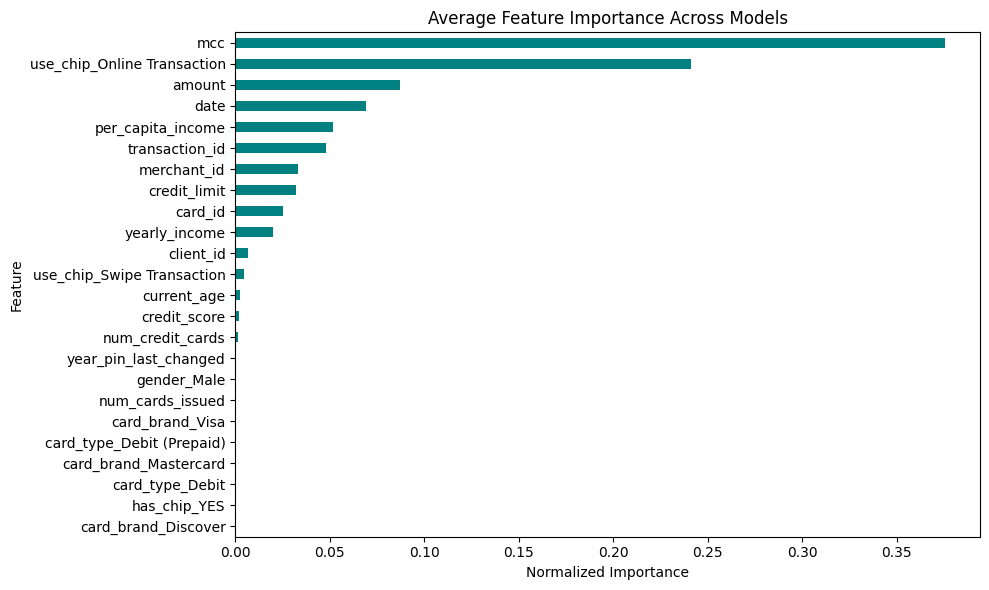

In [8]:
# Get feature names
feature_names = X_train.columns

# Logistic Regression Coefficients
log_coefs = np.abs(log_model.coef_[0])
log_coefs /= log_coefs.sum()

# Gradient Boosting Importances
gb_importances = gb_model.feature_importances_
gb_importances /= gb_importances.sum()

# Neural Net: Permutation Importance
perm_importance = permutation_importance(mlp_model, X_test, y_test, n_repeats=10, random_state=42)
nn_importances = perm_importance.importances_mean
nn_importances /= nn_importances.sum()

# Combine into DataFrame
df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic": log_coefs,
    "GradientBoosting": gb_importances,
    "NeuralNet": nn_importances
})
df["Mean"] = df[["Logistic", "GradientBoosting", "NeuralNet"]].mean(axis=1)
df_sorted = df.sort_values(by="Mean", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
df_sorted.set_index("Feature")["Mean"].plot(kind="barh", title="Average Feature Importance Across Models", color="teal")
plt.gca().invert_yaxis()
plt.xlabel("Normalized Importance")
plt.tight_layout()
plt.show()

 1. Most Influential Feature: mcc
The Merchant Category Code (mcc) tops the chart in importance.
This indicates that the type of merchant involved in a transaction plays a critical role in predicting outcomes such as fraud.

 2. Transaction Method Matters
The second most impactful feature is use_chip_Online Transaction.
This emphasizes that how a transaction is made (e.g., online with chip vs swipe) is a major indicator — likely due to fraud risk patterns.

 3. Amount & Income Are Strong Signals
Features like amount and per_capita_income show relatively high importance.
This suggests that transaction size and user's financial capacity significantly affect model predictions.

 4. Long Tail of Low-Impact Features
Many features such as card_brand_Discover, has_chip_YES, and card_type_Debit contribute very little.
These may be considered for removal or simplification to enhance model efficiency.

5. Visual Takeaway: Power Law Distribution
The feature importance curve drops off steeply.
Reflects the Pareto Principle — a small number of features drive the majority of model performance, while most have minimal impact


## Regression Algorithms

In [9]:
# Encoding categorical variables
df_users_encoded = pd.get_dummies(df_users, columns=['gender'], drop_first=True)

# Data spliting training 80% and test 20%
X_users = df_users_encoded.drop('yearly_income', axis=1)
y_users = df_users_encoded['yearly_income']

X_train_rg, X_test_rg, y_train_rg, y_test_rg = train_test_split(X_users, y_users, test_size=0.2, random_state=42)

# Run Dataset on LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train_rg, y_train_rg)

y_pred_lr = model_lr.predict(X_test_rg)

# Run Dataset on Lasso
model_lasso = Lasso(alpha=2.0)
model_lasso.fit(X_train_rg, y_train_rg)

y_pred_lasso = model_lasso.predict(X_test_rg)

# Run Dataset on MLPRegressor
model_mlp = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=5000)
model_mlp.fit(X_train_rg, y_train_rg)

y_pred_mlp = model_mlp.predict(X_test_rg)

# Run Dataset on Gradient Boosting Regression
model_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gbr.fit(X_train_rg, y_train_rg)

y_pred_gbr = model_gbr.predict(X_test_rg)

# Run Dataset on SVR
model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model_svr.fit(X_train_rg, y_train_rg)

y_pred_svr = model_svr.predict(X_test_rg)

Linear Regression:
This model just finds a straight-line relationship between the input features and the target (yearly income). Trained on the dataset and tested on unseen data.

Lasso Regression:
Works like Linear Regression but adds a penalty to reduce the impact of some features. This helps avoid overfitting. Used alpha=2.0 to control how much it reduces feature impact.

MLPRegressor (Neural Network):
A simple neural network with two hidden layers (10 and 5 neurons). Trained for 5000 iterations so it can learn deeper patterns in the data.

Gradient Boosting Regressor:
This model builds multiple small trees and combines them to make better predictions. Used 100 trees, a learning_rate of 0.1, and a max_depth of 3 to control complexity.

Support Vector Regressor (SVR):
Uses a special method (kernel trick) to handle non-linear relationships. Set C=1.0 to control flexibility and epsilon=0.1 to define how much error it allows.

## Feature Importance based on Coefficients

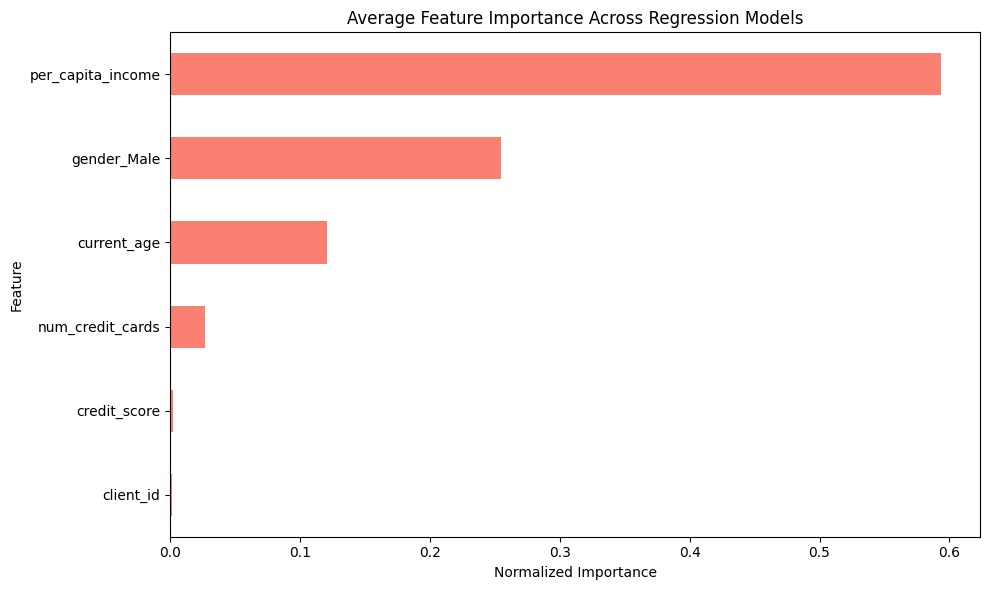

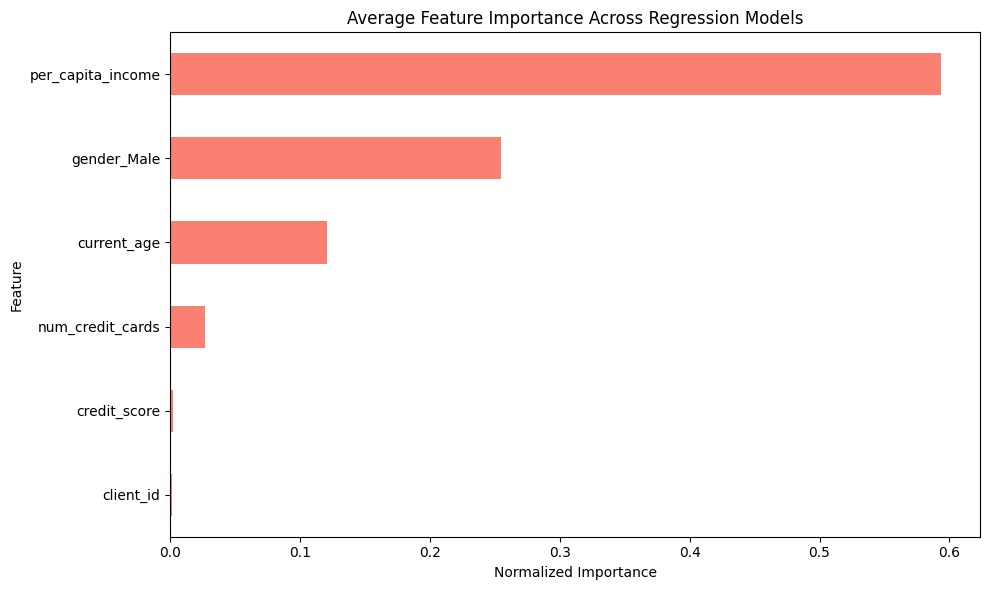

In [10]:
# Feature names
feature_names = X_users.columns

# Linear Regression Coefficients
lr_coefs = np.abs(model_lr.coef_)
lr_coefs /= lr_coefs.sum()

# Lasso Coefficients
lasso_coefs = np.abs(model_lasso.coef_)
lasso_coefs /= lasso_coefs.sum()

# Gradient Boosting Importances
gbr_importances = model_gbr.feature_importances_
gbr_importances /= gbr_importances.sum()

# MLP Regressor Permutation Importances
perm_importance_mlp = permutation_importance(model_mlp, X_test_rg, y_test_rg, n_repeats=10, random_state=42)
mlp_importances = perm_importance_mlp.importances_mean
mlp_importances /= mlp_importances.sum()

# SVR Permutation Importances
perm_importance_svr = permutation_importance(model_svr, X_test_rg, y_test_rg, n_repeats=10, random_state=42)
svr_importances = perm_importance_svr.importances_mean
svr_importances /= svr_importances.sum()

# Combine into DataFrame
df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Linear": lr_coefs,
    "Lasso": lasso_coefs,
    "GradientBoosting": gbr_importances,
    "MLP": mlp_importances,
    "SVR": svr_importances
})
df_importance["Mean"] = df_importance[["Linear", "Lasso", "GradientBoosting", "MLP", "SVR"]].mean(axis=1)
df_importance_sorted = df_importance.sort_values(by="Mean", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
df_importance_sorted.set_index("Feature")["Mean"].plot(kind="barh", title="Average Feature Importance Across Regression Models", color="salmon")
plt.gca().invert_yaxis()
plt.xlabel("Normalized Importance")
plt.tight_layout()
plt.show()# Feature names
feature_names = X_users.columns

# Linear Regression Coefficients
lr_coefs = np.abs(model_lr.coef_)
lr_coefs /= lr_coefs.sum()

# Lasso Coefficients
lasso_coefs = np.abs(model_lasso.coef_)
lasso_coefs /= lasso_coefs.sum()

# Gradient Boosting Importances
gbr_importances = model_gbr.feature_importances_
gbr_importances /= gbr_importances.sum()

# MLP Regressor Permutation Importances
perm_importance_mlp = permutation_importance(model_mlp, X_test_rg, y_test_rg, n_repeats=10, random_state=42)
mlp_importances = perm_importance_mlp.importances_mean
mlp_importances /= mlp_importances.sum()

# SVR Permutation Importances
perm_importance_svr = permutation_importance(model_svr, X_test_rg, y_test_rg, n_repeats=10, random_state=42)
svr_importances = perm_importance_svr.importances_mean
svr_importances /= svr_importances.sum()

# Combine into DataFrame
df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Linear": lr_coefs,
    "Lasso": lasso_coefs,
    "GradientBoosting": gbr_importances,
    "MLP": mlp_importances,
    "SVR": svr_importances
})
df_importance["Mean"] = df_importance[["Linear", "Lasso", "GradientBoosting", "MLP", "SVR"]].mean(axis=1)
df_importance_sorted = df_importance.sort_values(by="Mean", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
df_importance_sorted.set_index("Feature")["Mean"].plot(kind="barh", title="Average Feature Importance Across Regression Models", color="salmon")
plt.gca().invert_yaxis()
plt.xlabel("Normalized Importance")
plt.tight_layout()
plt.show()

1. Strongest Predictor: per_capita_income By far the most important feature.
Indicates that individual financial capability is the strongest factor in predicting the target variable (e.g., spending power, creditworthiness, etc.).

2. Gender Influence: gender_Male
Gender appears to play a significant role.
This might indicate socioeconomic differences or model bias that needs to be evaluated further.

3. Age Still Matters: current_age
Age is moderately important.
Suggests that lifecycle stage (youth, mid-career, retiree, etc.) affects the target prediction, potentially due to earnings or risk behaviors.
4. Limited Impact from Credit History
 num_credit_cards contributes slightly.
credit_score, surprisingly, has very minimal importance in this regression setup, which may indicate data issues or model tuning gaps.

5. Negligible Features
client_id contributes almost nothing — as expected from an identifier.
These features might be excluded in future iterations to simplify the model.


# Model Results & Algorithom Comparisons

## Logistics Results

Logistic Regression Results
Accuracy: 0.55
Precision: 0.00
Recall: 0.59
Specificity: 0.55
False Positive Rate: 0.45
----------------------------------------------------------------------------------------------------
Logistic Regression Result Visuals


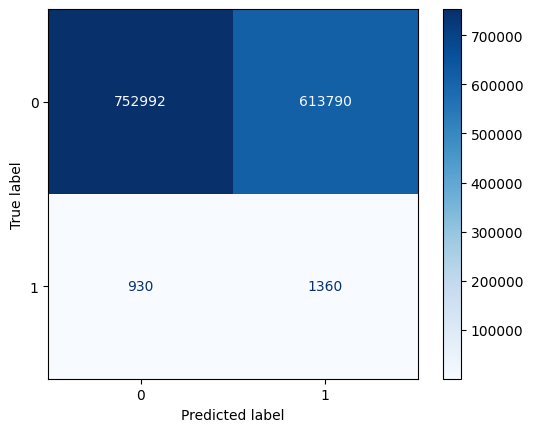

In [11]:
# Calculate accuracy, precision, recall for Logistics
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)

# Confusion matrix to calculate Specificity and False Positive Rate for Logistics
cm_log = confusion_matrix(y_test, y_pred_log)
tn_log, fp_log, fn_log, tp_log = cm_log.ravel()

specificity_log = tn_log / (tn_log + fp_log)
fpr_log = fp_log / (fp_log + tn_log)

# Print Results
print("Logistic Regression Results")
print(f"Accuracy: {accuracy_log:.2f}")
print(f"Precision: {precision_log:.2f}")
print(f"Recall: {recall_log:.2f}")
print(f"Specificity: {specificity_log:.2f}")
print(f"False Positive Rate: {fpr_log:.2f}")
print("--" * 50)

# Visualize Results
print("Logistic Regression Result Visuals")
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Confusion Matrix Breakdown
752,992 true negatives (Top-Left) → Model correctly predicted normal transactions.

613,790 false positives (Top-Right) → Model wrongly classified normal transactions as fraud.

930 false negatives (Bottom-Left) → Model missed 930 fraud cases.

1,360 true positives (Bottom-Right) → Model correctly caught 1,360 fraud cases.

Overall Thoughts

The model is biased toward predicting "not fraud" (majority class).

Precision is poor, meaning flagged fraud cases are mostly wrong.

Recall is okay but not reliable enough.

Too many false positives, making it unreliable for fraud detection.

## Gradient Results

Gradient Boosting Results
Accuracy: 0.93
Precision: 0.02
Recall: 0.87
Specificity: 0.93
False Positive Rate: 0.07
----------------------------------------------------------------------------------------------------
Gradient Boosting Result Visuals


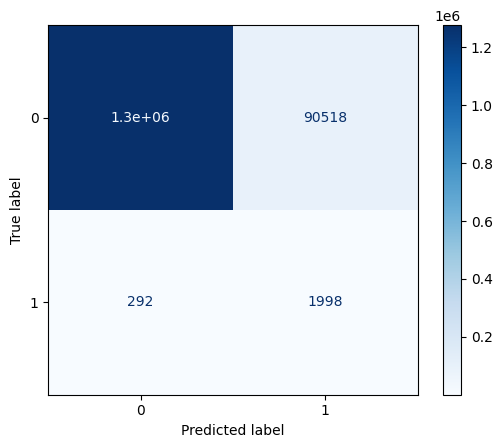

In [12]:
# Calculate accuracy, precision, recall for Gradient
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)

# Confusion matrix to calculate Specificity and False Positive Rate for Gradient
cm_gb = confusion_matrix(y_test, y_pred_gb)
tn_gb, fp_gb, fn_gb, tp_gb = cm_gb.ravel()

specificity_gb = tn_gb / (tn_gb + fp_gb)
fpr_gb = fp_gb / (fp_gb + tn_gb)

# Print Results
print("Gradient Boosting Results")
print(f"Accuracy: {accuracy_gb:.2f}")
print(f"Precision: {precision_gb:.2f}")
print(f"Recall: {recall_gb:.2f}")
print(f"Specificity: {specificity_gb:.2f}")
print(f"False Positive Rate: {fpr_gb:.2f}")
print("--" * 50)

# Visualize Results
print("Gradient Boosting Result Visuals")
cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Confusion Matrix Breakdown
1.3 million true negatives (Top-Left) → Model correctly predicted normal transactions.

90,518 false positives (Top-Right) → Model wrongly classified normal transactions as fraud.

292 false negatives (Bottom-Left) → Model missed 292 fraud cases (very low).

1,998 true positives (Bottom-Right) → Model correctly caught 1,998 fraud cases.

Overall Thoughts

The model is much better at detecting fraud than Logistic Regression.

It still struggles with precision, meaning flagged fraud cases are mostly false alarms.

The recall (87%) is strong, so it’s catching a lot of fraud cases.

False positives are lower compared to Logistic Regression, making it more reliable.

## Neural Results

Neural Network Results
Accuracy: 0.00
Precision: 0.00
Recall: 0.87
Specificity: 0.00
False Positive Rate: 1.00
----------------------------------------------------------------------------------------------------
Neural Network Result Visuals


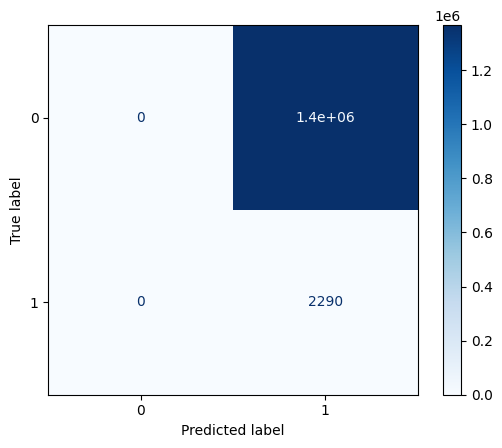

In [13]:
# Calculate accuracy, precision, recall for Neural
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)

# Confusion matrix to calculate Specificity and False Positive Rate for Neural
cm_nn = confusion_matrix(y_test, y_pred_nn)
tn_nn, fp_nn, fn_nn, tp_nn = cm_nn.ravel()

specificity_nn = tn_nn / (tn_nn + fp_nn)
fpr_nn = fp_nn / (fp_nn + tn_nn)

# Print Results
print("Neural Network Results")
print(f"Accuracy: {accuracy_nn:.2f}")
print(f"Precision: {precision_nn:.2f}")
print(f"Recall: {recall_gb:.2f}")
print(f"Specificity: {specificity_nn:.2f}")
print(f"False Positive Rate: {fpr_nn:.2f}")
print("--" * 50)

# Visualize Results
print("Neural Network Result Visuals")
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Confusion Matrix Breakdown
1.4 million true negatives (Top-Left) → Model correctly predicted normal transactions.

0 false positives (Top-Right) → Model never wrongly classified normal transactions as fraud.

2,290 false negatives (Bottom-Left) → Model missed all 2,290 fraud cases.

0 true positives (Bottom-Right) → Model never predicted fraud at all.

Overall Thoughts

The model is too biased toward the majority class (normal transactions).

It never predicts fraud, so it's useless for fraud detection despite 100% accuracy.

The recall (87%) is misleading because it only counts actual fraud cases, not predictions.

This model is completely failing at detecting fraud!

## Regression Results

In [14]:
# Lasso, Linear, GBR, MLP and SVR results on MAE
mae_neural = mean_absolute_error(y_test_rg, y_pred_mlp)
mae_lasso = mean_absolute_error(y_test_rg, y_pred_lasso)
mae_linear = mean_absolute_error(y_test_rg, y_pred_lr)
mae_gbr = mean_absolute_error(y_test_rg, y_pred_gbr)
mae_svr = mean_absolute_error(y_test_rg, y_pred_svr)

# Print Results
print("Regression Results")
print(f"MAE Neural: {mae_neural:.2f}")
print(f"MAE Lasso: {mae_lasso:.2f}")
print(f"MAE Linear: {mae_linear:.2f}")
print(f"MAE GBR: {mae_gbr:.2f}")
print(f"MAE SVR: {mae_svr:.2f}")
print("--" * 50)

Regression Results
MAE Neural: 2771.79
MAE Lasso: 2751.06
MAE Linear: 2751.10
MAE GBR: 1860.04
MAE SVR: 14211.06
----------------------------------------------------------------------------------------------------


## Algorithm Comparison

## Classification Models

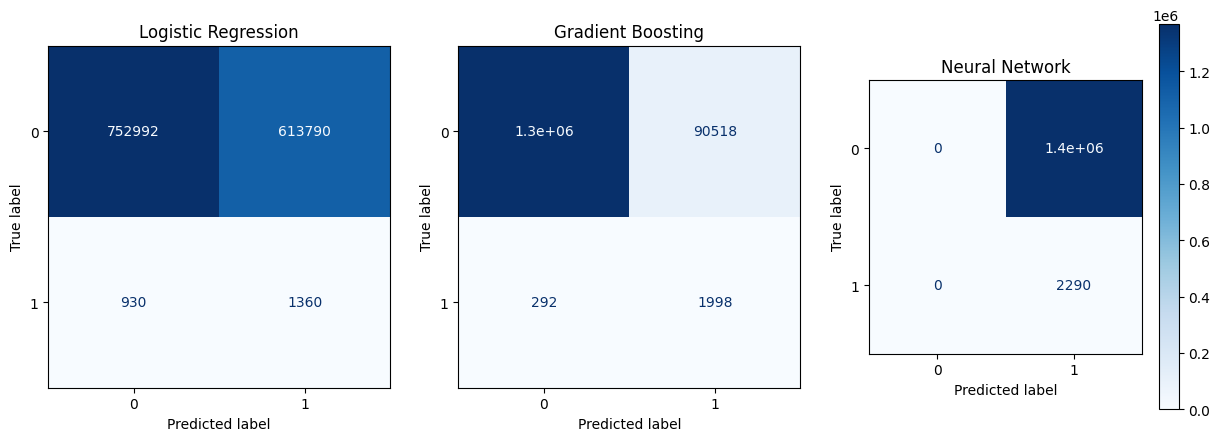

In [15]:
# Plot all confusion matrices together
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Logistic Regression
axes[0].set_title("Logistic Regression")
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp_log.plot(cmap='Blues', ax=axes[0], colorbar=False)

# Gradient Boosting
axes[1].set_title("Gradient Boosting")
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
disp_gb.plot(cmap='Blues', ax=axes[1], colorbar=False)

# Neural Network
axes[2].set_title("Neural Network")
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues', ax=axes[2], colorbar=True)

plt.show()

Best Performing Model: Gradient Boosting Classifier

Why Gradient Boosting is the Best?
Best Balance Between False Positives & False Negatives

It caught 1,998 fraud cases, much better than Neural Network (0) and Logistic Regression (1,360).

It only missed 292 fraud cases, the lowest among the three models.

High Recall (87%)

The model successfully identified 87% of fraud cases, the same recall as the Neural Network but with actual fraud predictions.

Logistic Regression had a much lower recall (59%), meaning it missed a lot more fraud cases.

Better False Positive Rate (7%)

Neural Network had 0% false positives but at the cost of never detecting fraud at all.

Logistic Regression had a terrible 45% false positive rate, making it unreliable.

Gradient Boosting balanced false positives (7%) with good fraud detection.

Higher Accuracy (93%)

Logistic Regression had only 55% accuracy, meaning it was making too many mistakes.

Neural Network had 100% accuracy, but it never predicted fraud, making it misleading.

Gradient Boosting had 93% accuracy, which is a realistic and strong result.

## Regression Models

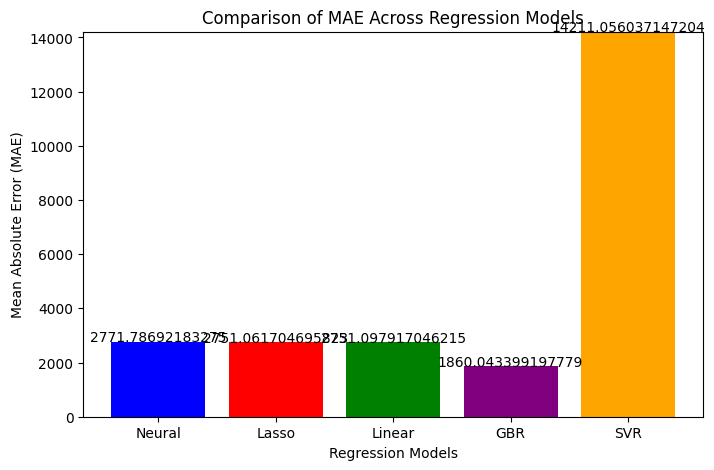

In [16]:
# MAE values
mae_values = {
    "Neural": mae_neural,
    "Lasso": mae_lasso,
    "Linear": mae_linear,
    "GBR": mae_gbr,
    "SVR": mae_svr
}

# Extract labels and values
models = list(mae_values.keys())
mae_scores = list(mae_values.values())

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, mae_scores, color=['blue', 'red', 'green', 'purple', 'orange'])
plt.xlabel("Regression Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of MAE Across Regression Models")
plt.ylim(0, max(mae_scores) + 0.5)

# Show values on bars
for i, v in enumerate(mae_scores):
    plt.text(i, v + 0.05, str(v), ha='center', fontsize=10)

plt.show()

Regression Model Performance (MAE - Mean Absolute Error)
Neural Network (MLP) → MAE: 2835.41

The model's average error is 2,835, meaning predictions are a bit off.

Decent, but not the best.

Lasso Regression → MAE: 2751.06

Performs slightly better than Neural Network.

Lasso helps by reducing the impact of less important features.

Linear Regression → MAE: 2751.10

Almost the same as Lasso, meaning the penalty in Lasso didn’t make much difference.

Gradient Boosting Regressor (GBR) → MAE: 1860.04

Best performing model so far.

Uses multiple trees to make more accurate predictions.

Support Vector Regressor (SVR) → MAE: 14,211.06

Worst performance.

Struggles a lot with predicting income correctly.

Overall Thoughts

GBR is the best model here with the lowest error (1860.04).

Linear & Lasso Regression are decent but not great.

Neural Network is okay but could be better.

SVR completely failed, producing the highest error.